# Classifying Adverse Drug Events (ADEs)

In [1]:
import pandas as pd
from datasets import load_dataset
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
from IPython.display import display, HTML

In [2]:
# Load dataset 
dataset = load_dataset("SetFit/ade_corpus_v2_classification")
df = dataset['train'].to_pandas()
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,text,label,label_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related
1,Median patient age was 52 years.,0,Not-Related
2,A whole brain irradiation was performed for 37...,0,Not-Related
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related
4,The fastidious organism grew only on buffered ...,0,Not-Related


### EDA

In [3]:
# Dataset size (observations and features)
n_obs, n_features = df.shape
print(f"Dataset size: {n_obs} observations, {n_features} features")

Dataset size: 17637 observations, 3 features


In [4]:
# Count of adverse drug events (label=1) vs non–adverse events (label=0)
n_ade = (df["label"] == 1).sum()
n_non_ade = (df["label"] == 0).sum()
print(f"Adverse drug events (label=1): {n_ade}")
print(f"Non–adverse events (label=0): {n_non_ade}")

Adverse drug events (label=1): 5145
Non–adverse events (label=0): 12492


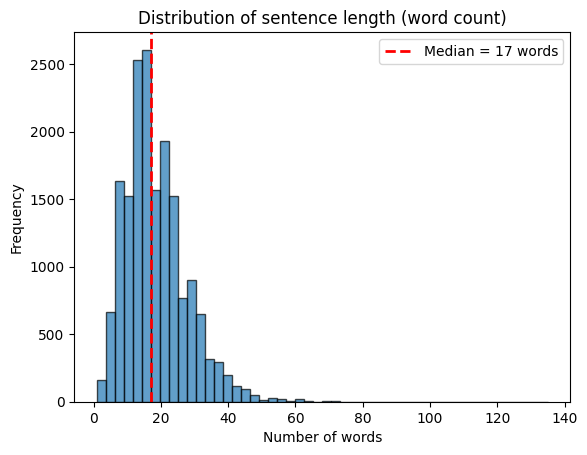

In [5]:
# Histogram of number of words per text, with median
import matplotlib.pyplot as plt

word_counts = df["text"].str.split().str.len()
median_words = word_counts.median()

fig, ax = plt.subplots()
ax.hist(word_counts, bins=50, edgecolor="black", alpha=0.7)
ax.axvline(median_words, color="red", linestyle="--", linewidth=2, label=f"Median = {median_words:.0f} words")
ax.set_xlabel("Number of words")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of sentence length (word count)")
ax.legend()
plt.show()

### Text Preprocessing

In [6]:
# Download NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/fayewu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/fayewu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/fayewu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Uses Penn Treebank POS tags to map parts of speech for better lemmatization with WordNet
def _get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  


def preprocess_text(text):
    """Lowercase, normalize whitespace, tokenize, remove punctuation/digits-only tokens, and lemmatize (POS-aware)."""
    if not isinstance(text, str) or not text.strip():
        return ''
    # Lowercase and normalize whitespace
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove tokens that are only punctuation/digits
    tokens = [t for t in tokens if re.search(r'[a-z]', t)]
    if not tokens:
        return ''

    # POS tag for better lemmatization
    pos_tags = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(token, pos=_get_wordnet_pos(tag))
        for token, tag in pos_tags
    ]
    return ' '.join(lemmatized)


df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,text,label,label_text,processed_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...
1,Median patient age was 52 years.,0,Not-Related,median patient age be year
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...


### Information Extraction (NER)
- Use the scispaCy BC5CDR model to extract chemicals and diseases from the raw 'text' column
- These chemicals and diseases can be used as extra information for a classification model

In [8]:
# scispaCy BC5CDR model: CHEMICAL (drugs) and DISEASE (conditions/adverse effects)
nlp = spacy.load("en_ner_bc5cdr_md")


def extract_ner_entities(text):
    """Extract drug (chemical) and disease/condition entities from text using scispaCy NER."""
    if not isinstance(text, str) or not text.strip():
        return [], []
    doc = nlp(text)
    drugs = [ent.text for ent in doc.ents if ent.label_ == "CHEMICAL"]
    diseases = [ent.text for ent in doc.ents if ent.label_ == "DISEASE"]
    return drugs, diseases


# Copy df and add NER-derived columns
df_ner = df.copy()
ner_results = df_ner["text"].apply(extract_ner_entities)
df_ner["drug_entities"] = [r[0] for r in ner_results]
df_ner["disease_entities"] = [r[1] for r in ner_results]

df_ner.head()

/opt/anaconda3/envs/pharma/lib/python3.8/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


,text,label,label_text,processed_text,drug_entities,disease_entities
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...,[],[]
1,Median patient age was 52 years.,0,Not-Related,median patient age be year,[],[]
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...,"[gefitinib, erlotinib]",[]
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...,[],"[hypocalcemia, hypoparathyroidism, leukemia]"
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...,[charcoal yeast extract],[]


#### NER Validation
- Taking samples of text and visualizing how the scispaCy model is classifying diseases and chemicals

In [11]:
from spacy import displacy
# Select a few random examples
sample_docs = df_ner[df_ner['drug_entities'].map(len) > 0].sample(5)['text']

for text in sample_docs:
    doc = nlp(text)
    
    # 1. Generate the HTML string with jupyter=False
    html = displacy.render(doc, style="ent", jupyter=False)
    
    # 2. Manually display the HTML using the correct import
    display(HTML(html))
    
    print("---")

---


---


---


---


---


## Classification Modeling

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
class NERFeatureExtractor(BaseEstimator, TransformerMixin):
    # Custom transformer to extract NER-based features
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Extract NER features from dataframe
        features = []
        for _, row in X.iterrows():
            # Binary features for presence of drugs/diseases
            has_drug = 1 if len(row['drug_entities']) > 0 else 0
            has_disease = 1 if len(row['disease_entities']) > 0 else 0
            
            # Count features
            drug_count = len(row['drug_entities'])
            disease_count = len(row['disease_entities'])
            
            # Combined feature: presence of both drug and disease
            has_both = 1 if (has_drug and has_disease) else 0
            
            features.append([has_drug, has_disease, drug_count, disease_count, has_both])
        
        return np.array(features)

# Prepare the data for modeling
df_model = df_ner.copy()

# Create features: text + NER features
X_text = df_model['processed_text'].values
X_ner_features = df_model[['drug_entities', 'disease_entities']]
y = df_model['label'].values

print(f"Dataset shape: {df_model.shape}")
print(f"Positive samples (ADE): {y.sum()}")
print(f"Negative samples: {len(y) - y.sum()}")

Dataset shape: (17637, 6)
Positive samples (ADE): 5145
Negative samples: 12492


In [14]:
# BASELINE MODELS
# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

# Define baseline models
baseline_models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Transform text data
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Train and evaluate baseline models
baseline_results = {}
for name, model in baseline_models.items():
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    baseline_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

Training samples: 14109
Test samples: 3528

Naive Bayes:
  Accuracy: 0.8319
  Precision: 0.8385
  Recall: 0.5248
  F1-Score: 0.6455

Logistic Regression:
  Accuracy: 0.8560
  Precision: 0.8396
  Recall: 0.6259
  F1-Score: 0.7171

Random Forest:
  Accuracy: 0.8724
  Precision: 0.8642
  Recall: 0.6676
  F1-Score: 0.7533

KNN:
  Accuracy: 0.7707
  Precision: 0.8873
  Recall: 0.2449
  F1-Score: 0.3839

SVM:
  Accuracy: 0.8741
  Precision: 0.8204
  Recall: 0.7279
  F1-Score: 0.7714


In [15]:
# Prepare combined dataset with NER features
X_combined = df_model[['processed_text', 'drug_entities', 'disease_entities']]
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Custom transformer for combined features
class CombinedFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
        self.ner_extractor = NERFeatureExtractor()
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        # Fit TF-IDF on text
        self.tfidf.fit(X['processed_text'])
        
        # Fit scaler on NER features
        ner_features = self.ner_extractor.transform(X)
        self.scaler.fit(ner_features)
        
        return self
    
    def transform(self, X):
        # Transform text
        text_features = self.tfidf.transform(X['processed_text'])
        
        # Transform NER features
        ner_features = self.ner_extractor.transform(X)
        ner_features_scaled = self.scaler.transform(ner_features)
        
        # Combine features
        from scipy.sparse import hstack
        return hstack([text_features, ner_features_scaled])

# Create pipeline with combined features
combined_models = {
    'Logistic Regression (NER)': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest (NER)': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (NER)': SVC(kernel='linear', random_state=42, probability=True)
}

combined_results = {}
for name, model in combined_models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('features', CombinedFeaturesTransformer()),
        ('classifier', model)
    ])
    
    # Train
    pipeline.fit(X_train_combined, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test_combined)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    combined_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': pipeline
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


Logistic Regression (NER):
  Accuracy: 0.8815
  Precision: 0.8121
  Recall: 0.7726
  F1-Score: 0.7918

Random Forest (NER):
  Accuracy: 0.8957
  Precision: 0.8231
  Recall: 0.8183
  F1-Score: 0.8207

SVM (NER):
  Accuracy: 0.8900
  Precision: 0.8189
  Recall: 0.7998
  F1-Score: 0.8092


/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_41042/2875979603.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_41042/2875979603.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_41042/2875979603.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/26/xmt10bgd4dlfjmnyqq13sfw80000gn/T/ipykernel_41042/2875979603.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


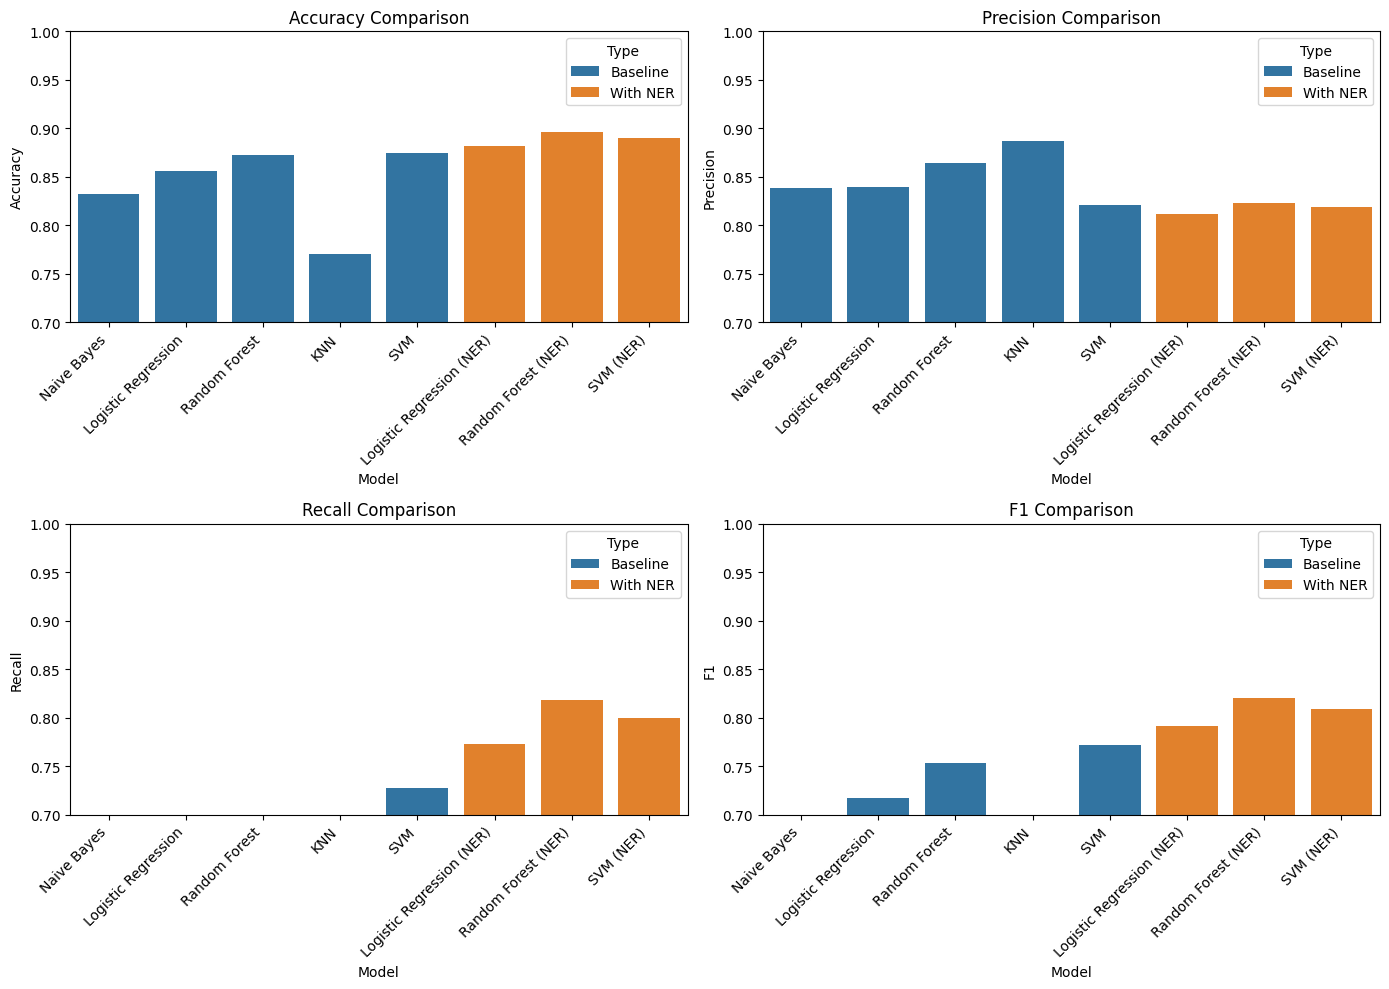

In [16]:
# Compare baseline vs NER-enhanced models
comparison_data = []
for name, results in baseline_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'Baseline'
    })

for name, results in combined_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'With NER'
    })

comparison_df = pd.DataFrame(comparison_data)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sns.barplot(data=comparison_df, x='Model', y=metric, hue='Type', ax=ax)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0.7, 1.0)

plt.tight_layout()
plt.show()

BEST MODEL: Random Forest (NER)

Classification Report:
              precision    recall  f1-score   support

     Not ADE       0.93      0.93      0.93      2499
         ADE       0.82      0.82      0.82      1029

    accuracy                           0.90      3528
   macro avg       0.87      0.87      0.87      3528
weighted avg       0.90      0.90      0.90      3528



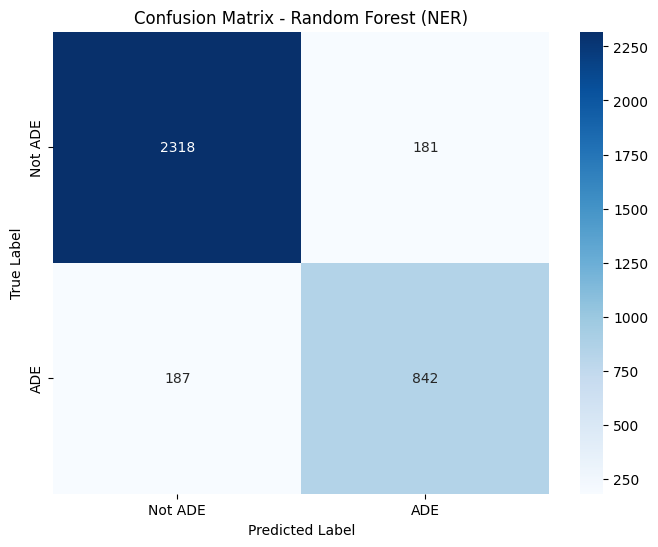

In [20]:
# Select best model based on F1-score
best_model_name = "Random Forest (NER)"
best_model = combined_results[best_model_name]['model']

print(f"BEST MODEL: {best_model_name}")

# Detailed evaluation of best model
y_pred = best_model.predict(X_test_combined)
y_pred_proba = best_model.predict_proba(X_test_combined)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not ADE', 'ADE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not ADE', 'ADE'], 
            yticklabels=['Not ADE', 'ADE'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

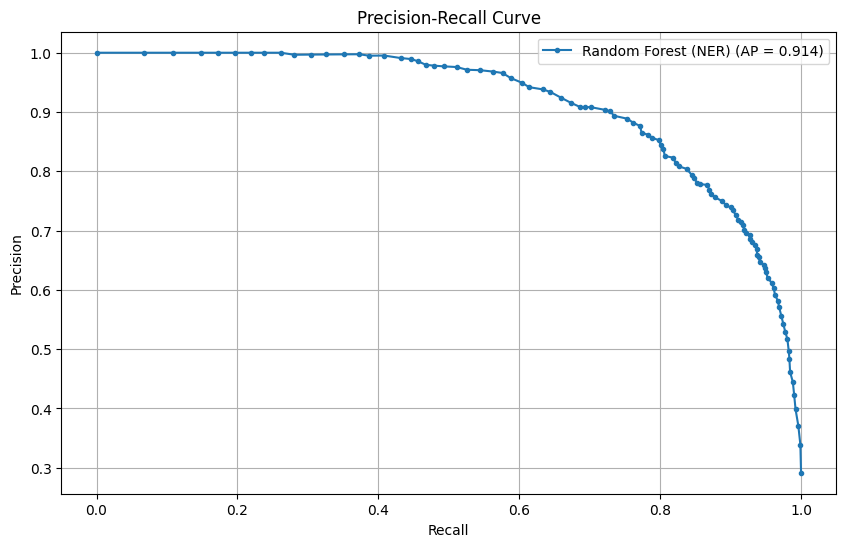

In [18]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label=f'Random Forest (NER) (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

 1. has_both                       : 0.077122
 2. drug_count                     : 0.057101
 3. has_drug                       : 0.053108
 4. disease_count                  : 0.033091
 5. induced                        : 0.025070
 6. has_disease                    : 0.019532
 7. develop                        : 0.014323
 8. associate                      : 0.009089
 9. induce                         : 0.007372
10. associated                     : 0.006658
11. report                         : 0.006402
12. case                           : 0.006031
13. patient                        : 0.005710
14. treatment                      : 0.005293
15. cause                          : 0.004339
16. therapy                        : 0.004298
17. acute                          : 0.004049
18. interferon                     : 0.003875
19. administration                 : 0.003714
20. toxicity                       : 0.003707


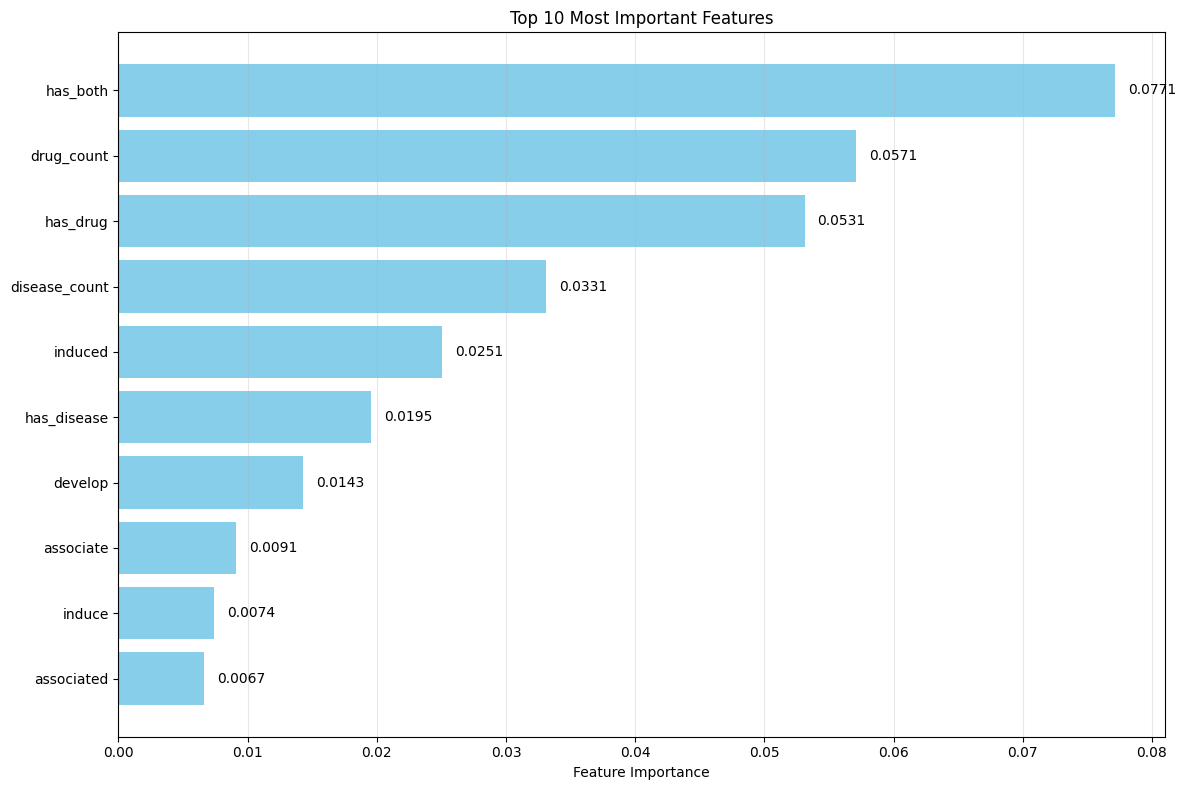

In [19]:
# FEATURE IMPORTANCE ANALYSIS
# Get feature importance from Random Forest
rf_model = best_model.named_steps['classifier']
feature_importances = rf_model.feature_importances_

# Get feature names
text_feature_names = best_model.named_steps['features'].tfidf.get_feature_names_out()
ner_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both']
all_feature_names = list(text_feature_names) + ner_feature_names

# Sort feature importances
sorted_idx = np.argsort(feature_importances)[::-1]

# Print top 20 features
for i in range(min(20, len(sorted_idx))):
    idx = sorted_idx[i]
    feat_name = all_feature_names[idx] if idx < len(all_feature_names) else f'Feature_{idx}'
    print(f"{i+1:2d}. {feat_name:30s} : {feature_importances[idx]:.6f}")

# Visualize top features
top_n = 10
top_indices = sorted_idx[:top_n]
top_features = [all_feature_names[i] if i < len(all_feature_names) else f'Feature_{i}' for i in top_indices]
top_importance = feature_importances[top_indices]

plt.figure(figsize=(12, 8))
bars = plt.barh(range(top_n), top_importance[::-1], color='skyblue')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Most Important Features')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_importance[::-1])):
    plt.text(val + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', va='center')

plt.tight_layout()
plt.show()